In [ ]:
from google.colab import userdata
token = userdata.get('hf_token')

In [ ]:
# !pip install bitsandbytes accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
from google.colab import userdata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
import re

In [ ]:
%%time

# 4-bit quantization config
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

# Load Mistral 7B model and tokenizer
model_name = "mistralai/Mistral-7B-Instruct-v0.1"
tokenizer = AutoTokenizer.from_pretrained(model_name, token=token)  # Updated parameter name
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    token=token,  # Updated parameter name
    quantization_config=quantization_config,
    device_map="auto"
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): MistralRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): Mist

In [ ]:
%%time

# Load and preprocess data
data = pd.read_csv('/content/weatherHistory.csv')
data['Formatted Date'] = pd.to_datetime(data['Formatted Date'], utc=True)
data = data.sort_values('Formatted Date')
temperature_series = data['Temperature (C)'].values

# Check data length
n_days_input = 365 * 24  # 12 months
n_days_predict = 31 * 24  # 1 month
# if len(temperature_series) < n_days_input + n_days_predict:
#     print(f"Warning: Only {len(temperature_series)} days available, need {n_days_input + n_days_predict}. Adjusting.")
#     n_days_input = max(len(temperature_series) - n_days_predict, 1)
#     n_days_predict = len(temperature_series) - n_days_input

# Split data
input_data = temperature_series[:n_days_input]  # First 365 days
actual_future = temperature_series[n_days_input:n_days_input + n_days_predict]  # Next 31 days

CPU times: user 1.37 s, sys: 11.1 ms, total: 1.38 s
Wall time: 1.38 s


In [ ]:
print(len(input_data))
print(len(actual_future))

8760
744


In [ ]:
# Extract the answer
def extract_numbers(text):
    matches = re.findall(r"[-+]?\d*\.\d+|\d+", text)
    return [float(m) for m in matches] if matches else []

def query_mistral_full_year(input_series):
    # Truncate or summarize input if too long (Mistral 7B context limit ~4096 tokens)
    input_str = str(input_series.tolist())
    print(f"The length of the input is: {len(input_str)}")

    prompt = f"Given the daily houry temperatures that is 8760 inputz for the past 1 year: {input_str}, predict the daily houry temperatures for the next 31 days in Celsius that is 744 hours. Reply with a list of 744 numbers."
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=150,  # Enough for 31 numbers
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f"Raw output: {len(response)}, {response}")
    predicted_temps = extract_numbers(response)
    # Ensure we get 31 predictions, padding or truncating if needed
    if len(predicted_temps) < 31:
        predicted_temps.extend([predicted_temps[-1]] * (31 - len(predicted_temps)))  # Repeat last value
    elif len(predicted_temps) > 31:
        predicted_temps = predicted_temps[:31]
    return predicted_temps

In [ ]:
# Predict next 31 days
predicted_month = query_mistral_full_year(input_data)

The length of the input is: 154428


OutOfMemoryError: CUDA out of memory. Tried to allocate 43.72 GiB. GPU 0 has a total capacity of 14.74 GiB of which 5.07 GiB is free. Process 6018 has 9.67 GiB memory in use. Of the allocated memory 5.82 GiB is allocated by PyTorch, and 3.72 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

ValueError: x and y must have same first dimension, but have shapes (744,) and (31,)

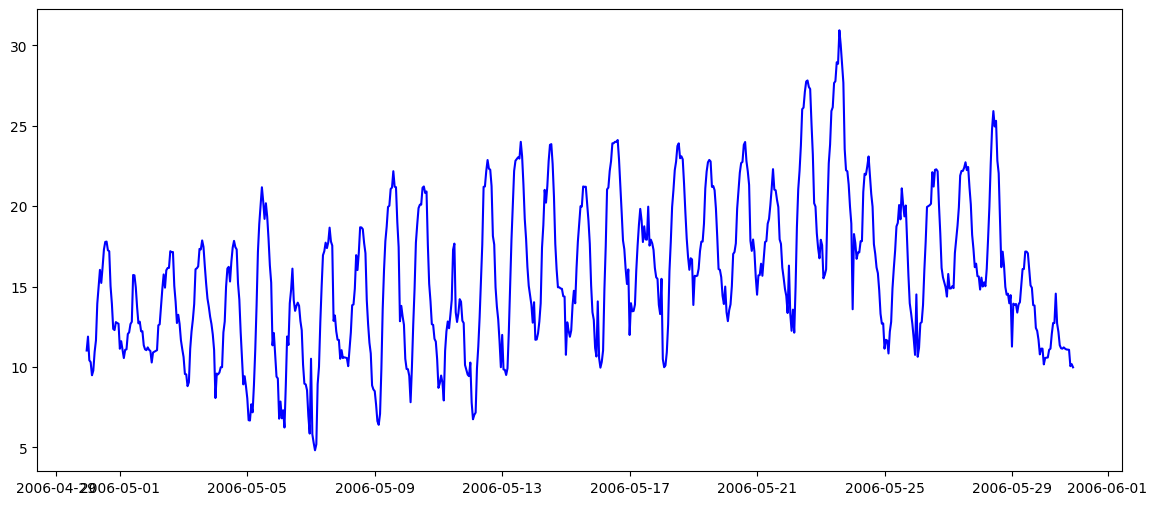

In [ ]:
last_input_date = data['Formatted Date'].iloc[n_days_input - 1]
future_dates = pd.date_range(start=last_input_date + pd.Timedelta(days=1), periods=n_days_predict, freq='1D')
input_dates = data['Formatted Date'].iloc[n_days_input - n_days_predict:n_days_input]

# Plot
plt.figure(figsize=(14, 6))
plt.plot(
    input_dates,
    input_data[-n_days_predict:],
    label='Actual (Last 31 Days)',
    color='blue'
)
plt.plot(
    future_dates,
    predicted_month,
    label='Predicted (Next 31 Days)',
    color='orange'
)
plt.plot(
    future_dates,
    actual_future,
    label='Original (Next 31 Days)',
    color='green',
    linestyle='--'
)
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.title('Temperature Forecasting: 1 Year Input + 1 Month Prediction vs Original')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Metrics
mae = mean_absolute_error(actual_future, predicted_month)
mse = mean_squared_error(actual_future, predicted_month)
rmse = np.sqrt(mse)
r2 = r2_score(actual_future, predicted_month)
print("\nMetrics (Predicted vs Original):")
print(f"MAE: {mae:.2f} °C")
print(f"MSE: {mse:.2f} °C²")
print(f"RMSE: {rmse:.2f} °C")
print(f"R²: {r2:.2f}")


Metrics (Predicted vs Original):
MAE: 6.65 °C
MSE: 60.30 °C²
RMSE: 7.77 °C
R²: -4.91
